# Add model: translation attention ecoder-decocer over the b4 dataset

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import pandas as pd
import unicodedata
import string
import re
import random
import copy
from contra_qa.plots.functions  import simple_step_plot, plot_confusion_matrix
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from nltk.translate.bleu_score import sentence_bleu


% matplotlib inline

In [2]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return '%s' % asMinutes(s)

### Preparing data

In [3]:
df2 = pd.read_csv("data/boolean4_train.csv")
df2_test = pd.read_csv("data/boolean4_test.csv")

df2["text"] = df2["sentence1"] + df2["sentence2"] 
df2_test["text"] = df2_test["sentence1"] + df2_test["sentence2"] 

all_sentences = list(df2.text.values) + list(df2_test.text.values)

df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]

In [4]:
df2train.tail()

,sentence1,sentence2,and_A,and_B,label,text
8495,Tracy grew up and won the game,Tracy didn't grow up,Tracy grew up,Tracy won the game,1,Tracy grew up and won the gameTracy didn't gro...
8496,Dennis heard Dora and wore a white jacket,Dennis didn't wear a white jacket,Dennis heard Dora,Dennis wore a white jacket,1,Dennis heard Dora and wore a white jacketDenni...
8497,Candice caught a yellow fish and slept the night,Ben didn't sleep the night,Candice caught a yellow fish,Candice slept the night,0,Candice caught a yellow fish and slept the nig...
8498,Anna spent all my money and fought the law,Anna didn't spend all my money,Anna spent all my money,Anna fought the law,1,Anna spent all my money and fought the lawAnna...
8499,Joel sat on the chair and understood what I said,Joel didn't understand what I said,Joel sat on the chair,Joel understood what I said,1,Joel sat on the chair and understood what I sa...


In [5]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


example = "ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf"
print("Before:", example)
print()
print("After:", normalizeString(example))

Before: ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf

After: ddddda capoeeeeeee ! ! aas fdf


In [7]:
pairs_A = list(zip(list(df2train.sentence1.values), list(df2train.and_A.values)))
pairs_B = list(zip(list(df2train.sentence1.values), list(df2train.and_B.values)))
pairs_A = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A]
pairs_B = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B]
pairs_A_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_A.values)))
pairs_B_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_B.values)))
pairs_A_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A_val]
pairs_B_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B_val]


In [8]:
all_text_pairs = zip(all_sentences, all_sentences)
all_text_pairs = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in all_text_pairs]

In [9]:
def readLangs(lang1, lang2, pairs, reverse=False):
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [tuple(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [10]:
f = lambda x: len(x.split(" "))

MAX_LENGTH = np.max(list(map(f, all_sentences)))

In [11]:
def filterPair(p):
    cond1 = len(p[0].split(' ')) < MAX_LENGTH
    cond2 = len(p[1].split(' ')) < MAX_LENGTH 
    return cond1 and cond2

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [12]:
def prepareData(lang1, lang2, pairs, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, pairs, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [13]:
_, _, training_pairs_A = prepareData("eng_enc",
                                             "eng_dec",
                                             pairs_A)

print()


input_lang, _, _ = prepareData("eng_enc",
                               "eng_dec",
                               all_text_pairs)

output_lang = copy.deepcopy(input_lang)

print()

print()
_, _, valid_pairs_A = prepareData("eng_enc",
                                "eng_dec",
                                pairs_A_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 1027
eng_dec 1020

Read 11000 sentence pairs
Trimmed to 10978 sentence pairs
Counting words...
Counted words:
eng_enc 10962
eng_dec 10962


Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 979
eng_dec 955


In [14]:
_, _, training_pairs_B = prepareData("eng_enc",
                                     "eng_dec",
                                     pairs_B)
print()
_, _, valid_pairs_B = prepareData("eng_enc",
                                "eng_dec",
                                pairs_B_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 1027
eng_dec 1022

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 979
eng_dec 946


### sentences 2 tensors

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [16]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [17]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [18]:
def tensorsFromTriple(triple):
    input_tensor = tensorFromSentence(input_lang, triple[0])
    target_tensor = tensorFromSentence(output_lang, triple[1])
    label_tensor = torch.tensor(triple[2], dtype=torch.long).view((1))
    return (input_tensor, target_tensor, label_tensor)

### models

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [21]:
hidden_size = 256
eng_enc_v_size = input_lang.n_words
eng_dec_v_size = output_lang.n_words

In [22]:
input_lang.n_words

10962

In [23]:
encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("b4_encoder1_att.pkl"))
decoderA.load_state_dict(torch.load("b4_decoder1_att.pkl"))

In [24]:
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("b4_encoder2_att.pkl"))
decoderB.load_state_dict(torch.load("b4_decoder2_att.pkl"))

## translating

In [25]:
def translate(encoder,
              decoder,
              sentence,
              max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()

        return " ".join(decoded_words)

## translation of a trained model: and A

In [26]:
for t in training_pairs_A[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoderA,
                                   decoderA,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

input_sentence : reginald caught a mango fish and ran from me
neural translation : jeffrey caught a mango fish <EOS>
reference translation : reginald caught a mango fish <EOS>
blue score = 0.76

input_sentence : sandy thought i was living in craiova and grew up in jail
neural translation : deborah thought i was helping in this <EOS>
reference translation : sandy thought i was living in craiova <EOS>
blue score = 0.42

input_sentence : brenda burned chris s house and let use this pen
neural translation : tyler broke julie s house <EOS>
reference translation : brenda burned chris s house <EOS>
blue score = 0.47



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


## translation of a trained model: and B

In [27]:
for t in training_pairs_B[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoderB,
                                   decoderB,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

input_sentence : reginald caught a mango fish and ran from me
neural translation : dianne ran from me <EOS>
reference translation : reginald ran from me <EOS>
blue score = 0.67

input_sentence : sandy thought i was living in craiova and grew up in jail
neural translation : grew grew up in jail <EOS>
reference translation : sandy grew up in jail <EOS>
blue score = 0.76

input_sentence : brenda burned chris s house and let use this pen
neural translation : let let use this pen <EOS>
reference translation : brenda let use this pen <EOS>
blue score = 0.76



## Defining the And model

model inner working:

- $s_1$ is the first sentence (e.g., 'penny is thankful and naomi is alive')

- $s_2$ is the second sentence (e.g., 'penny is not alive')

- $h_A = dec_{A}(enc_{A}(s_1, \vec{0}))$

- $h_B = dec_{B}(enc_{B}(s_1, \vec{0}))$

- $h_{inf} = \sigma (W[h_A ;h_B] + b)$

- $e = enc_{A}(s_2, h_{inf})$

- $\hat{y} = softmax(We + b)$

In [28]:
class AndModel(nn.Module):
    def __init__(self,
                 encoderA,
                 decoderA,
                 encoderB,
                 decoderB,
                 hidden_size,
                 output_size,
                 max_length,
                 input_lang,
                 target_lang,
                 SOS_token=0,
                 EOS_token=1):
        super(AndModel, self).__init__()
        self.max_length = max_length
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoderA = encoderA
        self.decoderA = decoderA
        self.encoderB = encoderB
        self.decoderB = decoderB
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.SOS_token = SOS_token
        self.EOS_token = EOS_token
        self.fc_inf = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    
    def encode(self,
               sentence,
               encoder,
               is_tensor,
               hidden=None):
        if not is_tensor:
            input_tensor = tensorFromSentence(self.input_lang, sentence)
        else:
            input_tensor = sentence

        input_length = input_tensor.size()[0]
        
        if hidden is None:
            encoder_hidden = encoder.initHidden()
        else:
            encoder_hidden = hidden
        
        encoder_outputs = torch.zeros(self.max_length,
                                      encoder.hidden_size,
                                      device=device)
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                        encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
            
        self.encoder_outputs = encoder_outputs

        return encoder_hidden
    
    
    def decode(self,
               tensor,
               decoder,
               out_tensor):
        
        decoder_input = torch.tensor([[self.SOS_token]], device=device)
        decoder_hidden = tensor
        decoded_words = []

        for di in range(self.max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, self.encoder_outputs)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == self.EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(self.target_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()
        
        if not out_tensor:
            output = " ".join(decoded_words)
        else:
            output = decoder_hidden

        return output
    
    def sen2vec(self, sentence, encoder, decoder, is_tensor, out_tensor):
        encoded = self.encode(sentence, encoder, is_tensor)
        vec = self.decode(encoded, decoder, out_tensor)
        return vec
    
    def sen2vecA(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderA, is_tensor)
        vec = self.decode(encoded, self.decoderA, out_tensor=True)
        return vec
    
    def sen2vecB(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderB, is_tensor)
        vec = self.decode(encoded, self.decoderB, out_tensor=True)
        return vec
    
    def forward(self, s1, s2):
        hA = self.sen2vecA(s1, is_tensor=True)
        hB = self.sen2vecB(s1, is_tensor=True)
#         h_inf = torch.cat([hA, hB], dim=2).squeeze(1)
#         h_inf = torch.sigmoid(self.fc_inf(h_inf))
#         h_inf = h_inf.view((1, h_inf.shape[0], h_inf.shape[1]))
        h_inf = hA
        e = self.encode(s2,
                        self.encoderA,
                        hidden=h_inf,
                        is_tensor=True)
        output = self.fc_out(e).squeeze(1)
        
        return output
    

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

        


In [29]:
addmodel = AndModel(encoderA,
                    decoderA,
                     encoderB,
                     decoderB,
                     hidden_size=256,
                     output_size=2,
                     max_length=MAX_LENGTH,
                     input_lang=input_lang,
                     target_lang=output_lang)

Test encoding decoding

In [30]:
for ex in training_pairs_B[0:3]:
    print("===========")
    ex = ex[0]
    print("s1:\n")
    print(ex)
    print()

    
    ex_A = addmodel.sen2vec(ex,
                     addmodel.encoderA,
                     addmodel.decoderA,
                     is_tensor=False,
                     out_tensor=False)
    
    ex_B = addmodel.sen2vec(ex,
                     addmodel.encoderB,
                     addmodel.decoderB,
                     is_tensor=False,
                     out_tensor=False)

    print("inference A:\n")
    print(ex_A)
    print()
    print("inference B:\n")
    print(ex_B)

s1:

reginald caught a mango fish and ran from me

inference A:

jeffrey caught a mango fish <EOS>

inference B:

dianne ran from me <EOS>
s1:

sandy thought i was living in craiova and grew up in jail

inference A:

deborah thought i was helping in this <EOS>

inference B:

grew grew up in jail <EOS>
s1:

brenda burned chris s house and let use this pen

inference A:

tyler broke julie s house <EOS>

inference B:

let let use this pen <EOS>


In [31]:
for ex in training_pairs_B[0:1]:
    print("===========")
    ex = ex[0]
    print("s1:\n")
    print(ex)
    print()

    ex_A = addmodel.sen2vecA(ex,is_tensor=False)
    ex_B = addmodel.sen2vecB(ex,is_tensor=False)
    
    print(ex_A)
    print()
    print(ex_B)

s1:

reginald caught a mango fish and ran from me

tensor([[[-0.9302, -0.0787,  0.7124,  0.9991, -0.9966, -0.9364, -1.0000,
           0.9999, -0.9718, -0.9295, -0.7621, -0.9978, -0.9916, -0.9981,
          -0.8200,  0.8686,  0.7113,  0.9979,  0.2876,  0.8455, -0.9989,
          -0.9780, -0.7723,  0.9986, -0.1284, -0.1883,  0.8014,  0.9965,
           0.4519,  0.7533, -0.7154,  0.9604,  0.8229, -0.9921, -0.9732,
           0.8040, -0.9998, -0.9518, -0.5616, -0.7952,  0.9616, -0.6224,
           0.4885,  0.1076,  0.9455,  0.9925, -0.7155,  0.2615,  0.9752,
           0.7439, -0.9034, -0.9419,  0.9267,  0.5234, -0.9488, -0.9977,
           0.9337, -0.9963,  0.8114,  0.0711,  0.9869,  0.9958, -0.9747,
          -0.7384,  0.8916,  0.8905,  0.6112, -0.9264, -0.6011, -0.9333,
           0.6591,  0.8238,  0.8844, -0.4638, -0.9676, -0.6012, -0.9991,
          -0.9969,  0.9471, -0.9747, -0.9996, -0.9999,  0.8353,  0.9790,
           0.3658, -0.9984, -0.8779, -0.9948, -0.0422, -0.8780,  0.9962,


In [32]:
train_triples = zip(list(df2train.sentence1.values), list(df2train.sentence2.values), list(df2train.label.values))
train_triples = [(normalizeString(s1), normalizeString(s2), l) for s1, s2, l in train_triples]
train_triples_t = [tensorsFromTriple(t) for t in train_triples]

In [33]:
train_triples = zip(list(df2train.sentence1.values), list(df2train.sentence2.values), list(df2train.label.values))
train_triples = [(normalizeString(s1), normalizeString(s2), l) for s1, s2, l in train_triples]
train_triples_t = [tensorsFromTriple(t) for t in train_triples]

In [34]:
valid_triples = zip(list(df2valid.sentence1.values), list(df2valid.sentence2.values), list(df2valid.label.values))
valid_triples = [(normalizeString(s1), normalizeString(s2), l) for s1, s2, l in valid_triples]
valid_triples_t = [tensorsFromTriple(t) for t in valid_triples]

In [35]:
len(valid_triples_t)

1500

In [36]:
test_triples = zip(list(df2_test.sentence1.values), list(df2_test.sentence2.values), list(df2_test.label.values))
test_triples = [(normalizeString(s1), normalizeString(s2), l) for s1, s2, l in test_triples]
test_triples_t = [tensorsFromTriple(t) for t in test_triples]

In [37]:
example = train_triples[0]
print(example)
example_t = train_triples_t[0]
print(example_t)

('reginald caught a mango fish and ran from me', 'reginald didn t catch a mango fish', 1)
(tensor([[ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [49],
        [ 1]]), tensor([[ 2],
        [11],
        [12],
        [13],
        [ 4],
        [ 5],
        [ 6],
        [ 1]]), tensor([1]))


## Prediction BEFORE training

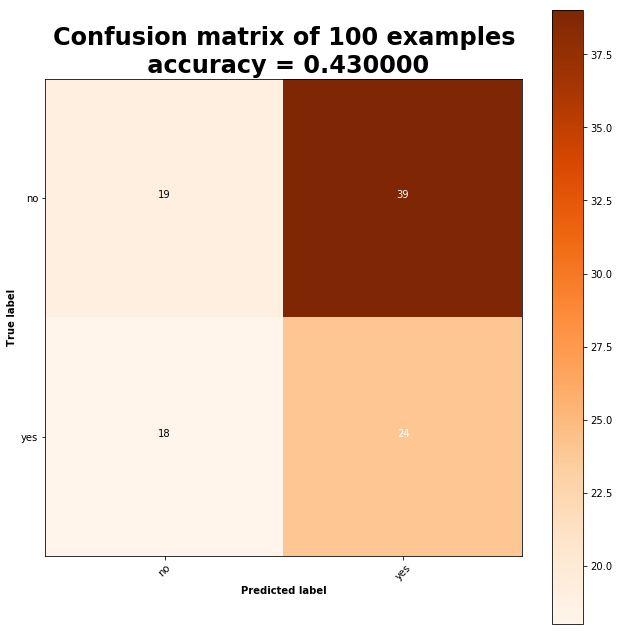

In [38]:
n_iters = 100
training_pairs_little = [random.choice(train_triples_t) for i in range(n_iters)]
predictions = []
labels = []

for i in range(n_iters):
    s1, s2, label = training_pairs_little[i]
    pred = addmodel.predict(s1, s2)
    label = label.item()
    pred = pred.item()
    predictions.append(pred)
    labels.append(label)

plot_confusion_matrix(labels,
                      predictions,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")

### Training functions

In [39]:
def CEtrain(s1_tensor,
            s2_tensor,
            label,
            model,
            optimizer,
            criterion):
    
    model.train()
    optimizer.zero_grad()
    logits = model(s1_tensor, s2_tensor)
    loss = criterion(logits, label)
    loss.backward()
    optimizer.step()
    return loss

Test CEtrain

In [40]:
CE = nn.CrossEntropyLoss()
addmodel_opt = torch.optim.SGD(addmodel.parameters(), lr= 0.3)

loss = CEtrain(s1_tensor=example_t[0],
               s2_tensor=example_t[1],
               label=example_t[2],
               model=addmodel,
               optimizer=addmodel_opt,
               criterion=CE)
assert type(loss.item()) == float 

## Little example of training

epoch 1/10 2m 50s mean loss = 1.48
epoch 2/10 2m 48s mean loss = 0.91
epoch 3/10 2m 47s mean loss = 0.84
epoch 4/10 2m 52s mean loss = 0.81
epoch 5/10 3m 4s mean loss = 0.79
epoch 6/10 3m 23s mean loss = 0.77
epoch 7/10 3m 25s mean loss = 0.79
epoch 8/10 3m 39s mean loss = 0.76
epoch 9/10 3m 20s mean loss = 0.76
epoch 10/10 3m 9s mean loss = 0.76


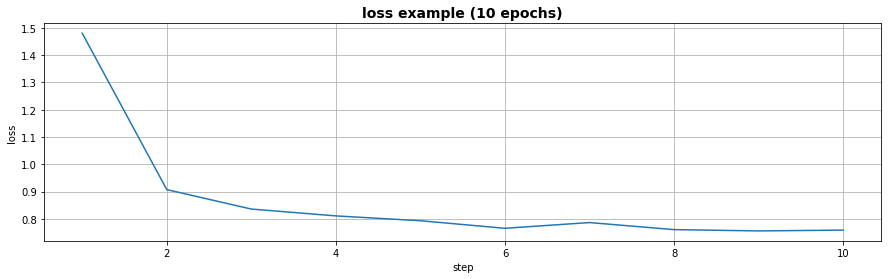

In [41]:
epochs = 10
learning_rate = 0.1

CE = nn.CrossEntropyLoss()

encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("b4_encoder1_att.pkl"))
decoderA.load_state_dict(torch.load("b4_decoder1_att.pkl"))
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("b4_encoder2_att.pkl"))
decoderB.load_state_dict(torch.load("b4_decoder2_att.pkl"))

addmodel = AndModel(encoderA,
                    decoderA,
                    encoderB,
                    decoderB,
                    hidden_size=256,
                    output_size=2,
                    max_length=MAX_LENGTH,
                    input_lang=input_lang,
                    target_lang=output_lang)



# # for model in [encoderA, decoderA, encoderB, decoderB]:
# for model in [encoderB, decoderB]:
#     for param in model.parameters():
#         param.requires_grad = False

# addmodel_opt = torch.optim.SGD(addmodel.parameters(), lr= learning_rate)
addmodel_opt = torch.optim.Adagrad(addmodel.parameters(), lr= learning_rate)
# addmodel_opt = torch.optim.Adadelta(addmodel.parameters(), lr= learning_rate)
# addmodel_opt = torch.optim.Adam(addmodel.parameters(), lr= learning_rate)
# addmodel_opt = torch.optim.SparseAdam(addmodel.parameters(), lr= learning_rate)
# addmodel_opt = torch.optim.RMSprop(addmodel.parameters(), lr= learning_rate)





losses_per_epoch = []

for i in range(epochs):
    losses = []
    start = time.time()
    n_iters = 1000
    training_pairs_little = [random.choice(train_triples_t) for i in range(n_iters)]
    for t in training_pairs_little:
        s1, s2, label = t    
        loss = CEtrain(s1_tensor=s1,
                       s2_tensor=s2,
                       label=label,
                       model=addmodel,
                       optimizer=addmodel_opt,
                       criterion=CE)
        losses.append(loss.item())
    mean_loss = np.mean(losses)
    losses_per_epoch.append(mean_loss)
    print("epoch {}/{}".format(i+1, epochs), timeSince(start), "mean loss = {:.2f}".format(mean_loss))

simple_step_plot([losses_per_epoch],
                 "loss",
                 "loss example ({} epochs)".format(epochs),
                 "loss_example.png",
                  figsize=(15,4))

## Prediction AFTER training

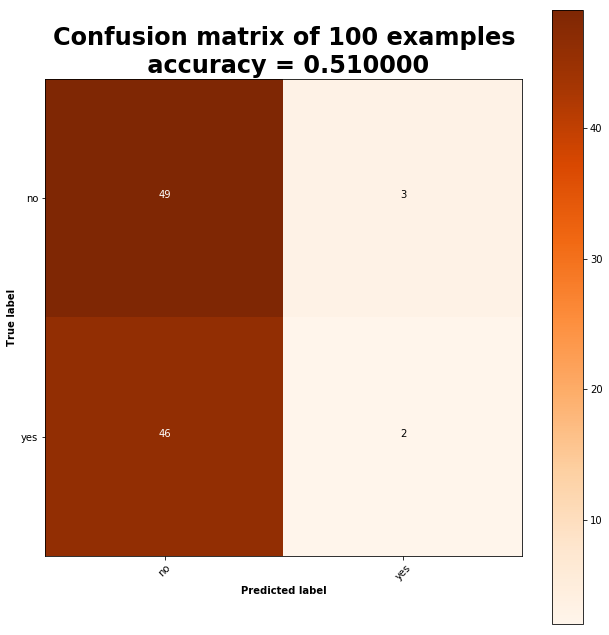

In [42]:
n_iters = 100
training_pairs_little = [random.choice(train_triples_t) for i in range(n_iters)]
predictions = []
labels = []

for i in range(n_iters):
    s1, s2, label = training_pairs_little[i]
    pred = addmodel.predict(s1, s2)
    label = label.item()
    pred = pred.item()
    predictions.append(pred)
    labels.append(label)

plot_confusion_matrix(labels,
                      predictions,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")

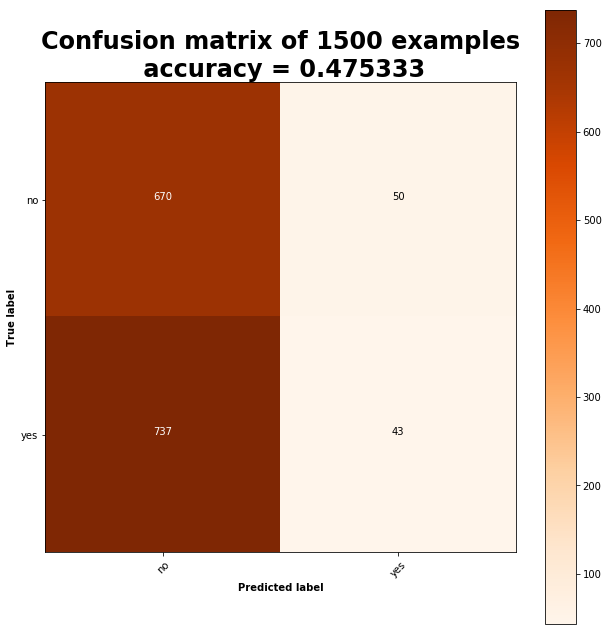

In [43]:
n_iters = len(valid_triples_t)
valid_pairs_little = [random.choice(valid_triples_t) for i in range(n_iters)]
predictions = []
labels = []

for i in range(n_iters):
    s1, s2, label = valid_pairs_little[i]
    pred = addmodel.predict(s1, s2)
    label = label.item()
    pred = pred.item()
    predictions.append(pred)
    labels.append(label)

plot_confusion_matrix(labels,
                      predictions,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")

In [44]:
torch.save(addmodel.state_dict(), "b4_simpleA.pkl")

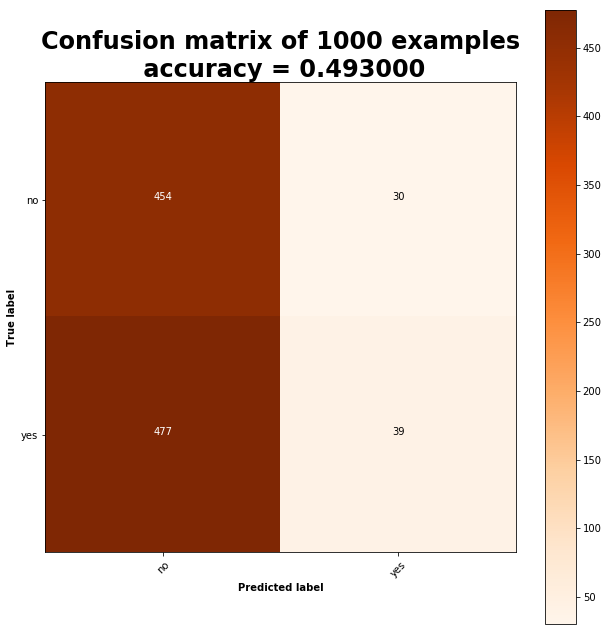

In [45]:
n_iters = len(test_triples_t)
test_pairs_little = [random.choice(test_triples_t) for i in range(n_iters)]
predictions = []
labels = []

for i in range(n_iters):
    s1, s2, label = test_pairs_little[i]
    pred = addmodel.predict(s1, s2)
    label = label.item()
    pred = pred.item()
    predictions.append(pred)
    labels.append(label)

plot_confusion_matrix(labels,
                      predictions,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")